### Word Frequency

In [1]:
import string
import pandas as pd
import numpy as np
import nltk
import re
from itertools import combinations, product
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stevenoluwaniyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1 & 2

We developed a scraper called "scrappy" that lives in the scrappy folder.

In [2]:
df = pd.read_csv('./scrappy/scrappy_do.csv')
# df = df[0:5000] # first 5000
df.head()

,date,userid,message
0,2002-03-25T05:54:02+00:00,merc1,I personally think that with a few tweaks the ...
1,2002-03-25T07:06:29+00:00,fredvh,I am debating a new purchase and these two are...
2,2002-03-25T17:02:27+00:00,blueguydotcom,"Great handling, RWD, excellent engine and the ..."
3,2002-03-25T23:04:37+00:00,hungrywhale,And no manual tranny. That may not matter to y...
4,2002-03-26T00:44:13+00:00,riez,One beauty of BMW 3 Series is that there are s...


### 3

In [34]:
modelsDF = pd.read_csv('./models.csv', names=['make', 'model'])
# this dataframe contains some other mappings like seat => seats
# for the makes / models will we ignore those, they are at the end
makemodels = modelsDF[0:520]
model_to_make = modelsDF.set_index('model').to_dict(orient='dict')['make']

def wordCount(post):
    d = {}
    l = str(post).lower().translate(translator).split(" ")
    filtered = [w for w in l if w not in stop_words]
    for w in filtered:
        d[w] = 1 if not d.get(w) else d[w] + 1
    return d

allText = ' '.join(list(map(lambda x: str(x), list(df['message']))))
counts = wordCount(allText)

def extractMakes(wordCounts):
    makes = {}
    for make in makemodels['make']:
        if wordCounts.get(make):
            makes[make] = wordCounts[make]
    return makes

def combineModels(makes, wordCounts):
    for row in makemodels.iterrows():
        make = row[1].make
        model = row[1].model
        if wordCounts.get(model):
            makes[make] += wordCounts.get(model)
    return makes
    
carCounts = combineModels(extractMakes(counts), counts)
carCounts = [(k, v) for k, v in carCounts.items()]
carCounts.sort(key=lambda x: x[1], reverse=True)
display(carCounts)

top10 = list(map(lambda c: c[0], carCounts[0:10]))
print('Top 10: {}'.format(top10))

[('bmw', 11757),
 ('audi', 5879),
 ('acura', 4755),
 ('honda', 3291),
 ('infiniti', 2734),
 ('toyota', 2365),
 ('volkswagen', 1609),
 ('nissan', 1338),
 ('volvo', 1172),
 ('chevrolet', 1063),
 ('mercedes', 996),
 ('ford', 957),
 ('hyundai', 954),
 ('cadillac', 929),
 ('subaru', 744),
 ('mazda', 604),
 ('lincoln', 558),
 ('buick', 475),
 ('dodge', 334),
 ('chrysler', 311),
 ('kia', 274),
 ('pontiac', 257),
 ('mercury', 61),
 ('mitsubishi', 60),
 ('saturn', 47),
 ('suzuki', 44)]

Top 10: ['bmw', 'audi', 'acura', 'honda', 'infiniti', 'toyota', 'volkswagen', 'nissan', 'volvo', 'chevrolet']


In [35]:
# Task C.

modelWords = list(modelsDF['make'].unique()) + list(modelsDF['model'].unique())

model_to_make = modelsDF.set_index('model').to_dict(orient='dict')['make']

countTuple = [(k, v) for k, v in counts.items()]
filtered = list(filter(lambda x: x[0] not in modelWords, countTuple))

filtered.sort(key=lambda x: x[1], reverse=True)
display('Example attributes sorted:', filtered[0:20])

attributes = ['performance', 'luxury', 'power', 'handling', 'speed']
print('Selected attributes are:', attributes)

'Example attributes sorted:'

[('', 16666),
 ('like', 7766),
 ('would', 7030),
 ('one', 7014),
 ('get', 5904),
 ('dont', 5320),
 ('new', 4990),
 ('think', 4869),
 ('tl', 4286),
 ('even', 4142),
 ('much', 3835),
 ('im', 3828),
 ('better', 3791),
 ('good', 3703),
 ('drive', 3654),
 ('well', 3629),
 ('3', 3356),
 ('really', 3291),
 ('know', 3256),
 ('people', 3106)]

Selected attributes are: ['performance', 'luxury', 'power', 'handling', 'speed']


### Task A.

In [37]:
def splitReplace(post):
    post = str(post).lower()
    
    post = post.translate(translator)
    modelKeys = model_to_make.keys()
    wordList = post.split(' ')
    
    for idx, word in enumerate(wordList):
        if word in modelKeys:
            wordList[idx] = model_to_make.get(word)
            
    unique = list(set(wordList))
    return unique if len(unique) else []
    

df['words'] = df['message'].map(lambda x: splitReplace(x))

In [38]:
def do_lift(x, y=None):
    l1, l2 = sorted(x), sorted(y or [])
    bools = pd.DataFrame()
    for e in l1 + l2:
        bools[e] = df['words'].map(lambda words: e in words)

    def do(df, a, b):
        count_a_int_b = np.logical_and(df[a], df[b]).values.sum()
        count_a_mult_count_b = df[a].values.sum() * df[b].values.sum()
        return len(df.index) * count_a_int_b / count_a_mult_count_b

    result_df = pd.DataFrame(index=l1, columns=(l2 or l1))
    for a, b in (combinations(l1, 2) if y==None else product(l1, l2)):
        val = do(bools, a, b)
        result_df.at[a, b] = val
        if y==None:
            result_df.at[b, a] = val

    return result_df

In [39]:
do_lift(top10)

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,NaN,2.25881,1.35088,1.34404,3.25366,3.17498,1.99418,1.72194,1.72271,2.50784
audi,2.25881,NaN,1.66233,1.58915,1.71347,2.43379,1.23376,1.57082,3.34349,3.1757
bmw,1.35088,1.66233,NaN,1.38111,1.18766,1.80204,1.25842,1.4399,1.28244,1.48912
chevrolet,1.34404,1.58915,1.38111,NaN,1.84124,1.51297,2.77944,2.54244,2.41639,2.01215
honda,3.25366,1.71347,1.18766,1.84124,NaN,1.50261,3.15628,3.4366,2.37887,1.77878
infiniti,3.17498,2.43379,1.80204,1.51297,1.50261,NaN,3.46296,1.81368,1.72915,2.53758
nissan,1.99418,1.23376,1.25842,2.77944,3.15628,3.46296,NaN,4.11521,2.52408,2.0085
toyota,1.72194,1.57082,1.4399,2.54244,3.4366,1.81368,4.11521,NaN,2.08856,2.26779
volkswagen,1.72271,3.34349,1.28244,2.41639,2.37887,1.72915,2.52408,2.08856,NaN,2.4455
volvo,2.50784,3.1757,1.48912,2.01215,1.77878,2.53758,2.0085,2.26779,2.4455,NaN


## Task B
BMW has the highest dissimilarity score across all the brands. This essentially means that the BMW market is more isolated than any other brand. Additionally, as shown in the figure above, Honda, Nissan, and Toyota form a cluster which implies that these brands are commonly mentioned together. As such, we can conclude that consumers think they're closely related and their markets overlap. 

### Continue Tasks

In [40]:
top_10_brands = do_lift(top10)

In [41]:
topBrandsList = list(top_10_brands.columns)

In [42]:
topBrandsList

['acura',
 'audi',
 'bmw',
 'chevrolet',
 'honda',
 'infiniti',
 'nissan',
 'toyota',
 'volkswagen',
 'volvo']

In [43]:
top_10_brands

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,NaN,2.25881,1.35088,1.34404,3.25366,3.17498,1.99418,1.72194,1.72271,2.50784
audi,2.25881,NaN,1.66233,1.58915,1.71347,2.43379,1.23376,1.57082,3.34349,3.1757
bmw,1.35088,1.66233,NaN,1.38111,1.18766,1.80204,1.25842,1.4399,1.28244,1.48912
chevrolet,1.34404,1.58915,1.38111,NaN,1.84124,1.51297,2.77944,2.54244,2.41639,2.01215
honda,3.25366,1.71347,1.18766,1.84124,NaN,1.50261,3.15628,3.4366,2.37887,1.77878
infiniti,3.17498,2.43379,1.80204,1.51297,1.50261,NaN,3.46296,1.81368,1.72915,2.53758
nissan,1.99418,1.23376,1.25842,2.77944,3.15628,3.46296,NaN,4.11521,2.52408,2.0085
toyota,1.72194,1.57082,1.4399,2.54244,3.4366,1.81368,4.11521,NaN,2.08856,2.26779
volkswagen,1.72271,3.34349,1.28244,2.41639,2.37887,1.72915,2.52408,2.08856,NaN,2.4455
volvo,2.50784,3.1757,1.48912,2.01215,1.77878,2.53758,2.0085,2.26779,2.4455,NaN


In [44]:
dissimilarity_matrix = 1/top_10_brands
np.fill_diagonal(dissimilarity_matrix.values, 0)
dissimilarity_matrix

,acura,audi,bmw,chevrolet,honda,infiniti,nissan,toyota,volkswagen,volvo
acura,0,0.442711,0.740256,0.744028,0.307347,0.314962,0.50146,0.580741,0.580482,0.39875
audi,0.442711,0,0.601564,0.629267,0.583611,0.410882,0.810528,0.636612,0.299089,0.314891
bmw,0.740256,0.601564,0,0.724057,0.841993,0.554926,0.794649,0.694491,0.779764,0.671536
chevrolet,0.744028,0.629267,0.724057,0,0.543113,0.660951,0.359785,0.393323,0.41384,0.49698
honda,0.307347,0.583611,0.841993,0.543113,0,0.665507,0.316828,0.290985,0.420368,0.562185
infiniti,0.314962,0.410882,0.554926,0.660951,0.665507,0,0.28877,0.551364,0.578317,0.394076
nissan,0.50146,0.810528,0.794649,0.359785,0.316828,0.28877,0,0.243001,0.396183,0.497883
toyota,0.580741,0.636612,0.694491,0.393323,0.290985,0.551364,0.243001,0,0.478799,0.440958
volkswagen,0.580482,0.299089,0.779764,0.41384,0.420368,0.578317,0.396183,0.478799,0,0.408914
volvo,0.39875,0.314891,0.671536,0.49698,0.562185,0.394076,0.497883,0.440958,0.408914,0


In [45]:
# Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

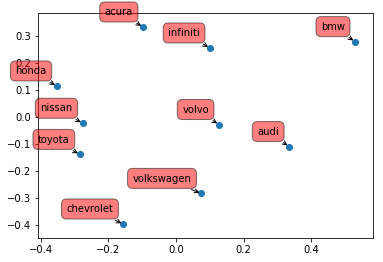

In [46]:
import matplotlib.pyplot as plt
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(topBrandsList, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

## Task C

In [47]:
## word counts

modelWords = list(modelsDF['make'].unique()) + list(modelsDF['model'].unique())

countTuple = [(k, v) for k, v in counts.items()]
filtered = list(filter(lambda x: x[0] not in modelWords, countTuple))

filtered.sort(key=lambda x: x[1], reverse=True)
display('Example attributes sorted:', filtered[0:20])

attributes = ['performance', 'luxury', 'power', 'handling', 'speed']
print('Selected attributes are:', attributes)

'Example attributes sorted:'

[('', 16666),
 ('like', 7766),
 ('would', 7030),
 ('one', 7014),
 ('get', 5904),
 ('dont', 5320),
 ('new', 4990),
 ('think', 4869),
 ('tl', 4286),
 ('even', 4142),
 ('much', 3835),
 ('im', 3828),
 ('better', 3791),
 ('good', 3703),
 ('drive', 3654),
 ('well', 3629),
 ('3', 3356),
 ('really', 3291),
 ('know', 3256),
 ('people', 3106)]

Selected attributes are: ['performance', 'luxury', 'power', 'handling', 'speed']


In [48]:
do_lift(top10[0:5], attributes)

,handling,luxury,performance,power,speed
acura,1.6829,2.03727,1.62576,1.85756,1.83004
audi,1.85199,1.89727,1.73898,1.93522,1.84652
bmw,1.79176,1.46202,1.62448,1.62643,1.3359
honda,1.67457,1.97196,1.51231,1.80006,1.95387
infiniti,1.60375,2.08745,1.77225,1.86246,1.55059


Handling: Audi

Luxury: Infiniti

Performance: Infiniti

Power: Audi

Speed: Honda

## TaskD


Acura:
Hight lux
lowest perf

Audi: 
highest in handling across brand
highest in power
lower perf

BMW: 
lowest in luxury, speed across brand
highest in handling within brand
[Secure] --> trying to make the brand seem safer as it's already established as a luxury car
rich people wanna be safe man --> keep the heirs safe


Honda:
lowest performance across brand
highest speed across brand

Usually speed and performance come hand in hand. Product manager --> lower the consumption of fuel, improve the breaks and better strappy things bc fast cars --> DO MORE RESEARCH ON THIS 



Infiniti:
lowest in handling across brand

Infiniti is trying to rebrand itself as a more luxurious brand; 
Handling has high frequency --> although it was highly recurring it might not have been in relation with infiniti 
usually used in comparisons?





In [31]:
## TASK E

do_lift(top10[0:5], ['love', 'aspire', 'want', 'dream', 'wish'])

,aspire,dream,love,want,wish
acura,1.78085,1.31374,1.87146,1.51717,1.34805
audi,3.79012,2.11818,2.05819,1.86406,1.92183
bmw,2.46141,2.07689,1.59364,1.61774,1.57191
honda,2.34205,1.15183,1.89126,1.57382,1.5396
infiniti,2.67292,1.31455,1.99582,1.79615,2.02332


In [ ]:
Aspire: Audi
Dream: Audi
Love: Audi
Want: Audi
Wish: Infiniti
    
do some research on Audi
    
